In [4]:
# 1. Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
import joblib

In [5]:
# Set  visualization style
sns.set(style="whitegrid", palette="muted", font_scale=1.2)
plt.rcParams["figure.figsize"] = (12, 6)

In [6]:
df = pd.read_csv('data_S/Obesity prediction1.csv')
print("Dataset shape:", df.shape)

Dataset shape: (2111, 17)


In [3]:
df.head()

,Gender,Age,Height,Weight,family_history,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Obesity
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          2111 non-null   object 
 1   Age             2111 non-null   float64
 2   Height          2111 non-null   float64
 3   Weight          2111 non-null   float64
 4   family_history  2111 non-null   object 
 5   FAVC            2111 non-null   object 
 6   FCVC            2111 non-null   float64
 7   NCP             2111 non-null   float64
 8   CAEC            2111 non-null   object 
 9   SMOKE           2111 non-null   object 
 10  CH2O            2111 non-null   float64
 11  SCC             2111 non-null   object 
 12  FAF             2111 non-null   float64
 13  TUE             2111 non-null   float64
 14  CALC            2111 non-null   object 
 15  MTRANS          2111 non-null   object 
 16  Obesity         2111 non-null   object 
dtypes: float64(8), object(9)
memory u

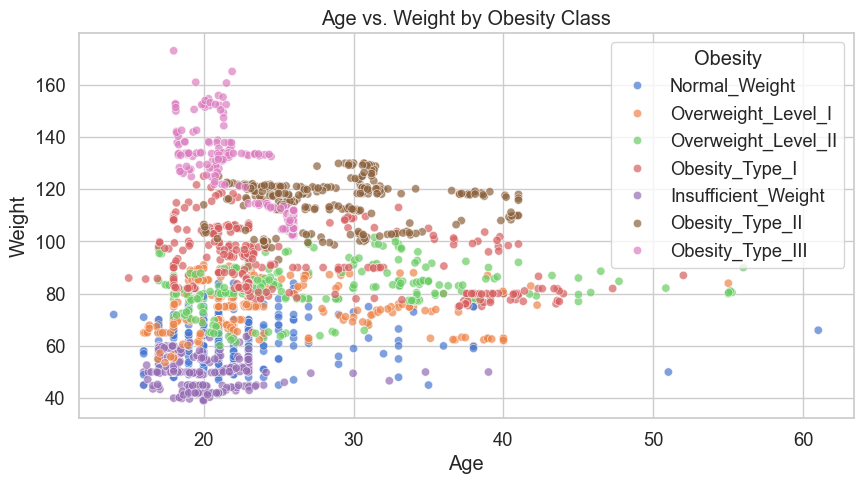

In [19]:
plt.figure(figsize=(10,5))
sns.scatterplot(x=df['Age'], y=df['Weight'], hue=df['Obesity'], alpha=0.7)
plt.title("Age vs. Weight by Obesity Class")
plt.show()

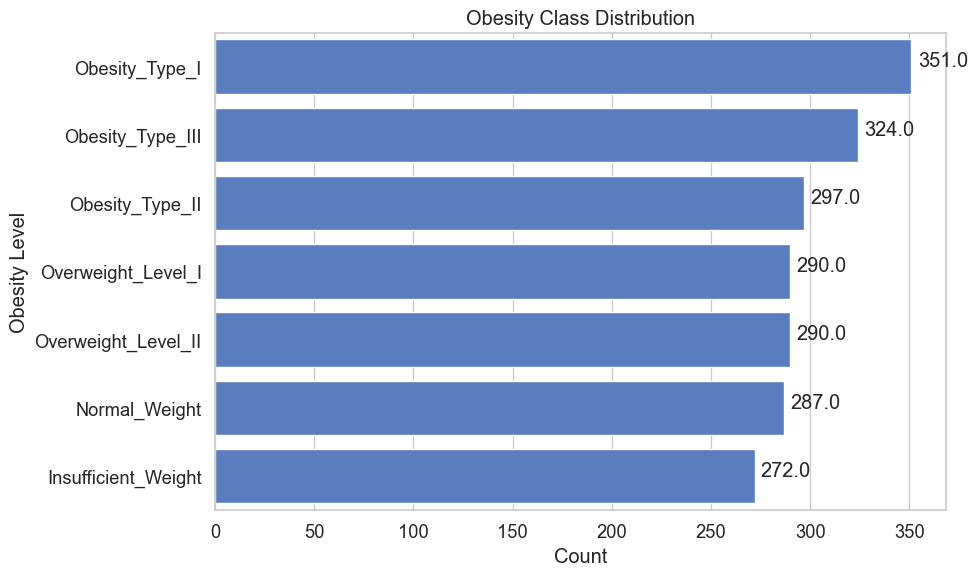

In [8]:
# ## 3. Exploratory Data Analysis (EDA)
# Target Variable Distribution
plt.figure(figsize=(10, 6))
ax = sns.countplot(y='Obesity', data=df, order=df['Obesity'].value_counts().index)
plt.title('Obesity Class Distribution')
plt.xlabel('Count')
plt.ylabel('Obesity Level')
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width()*1.01, p.get_y()+0.4))
plt.tight_layout()
plt.show()

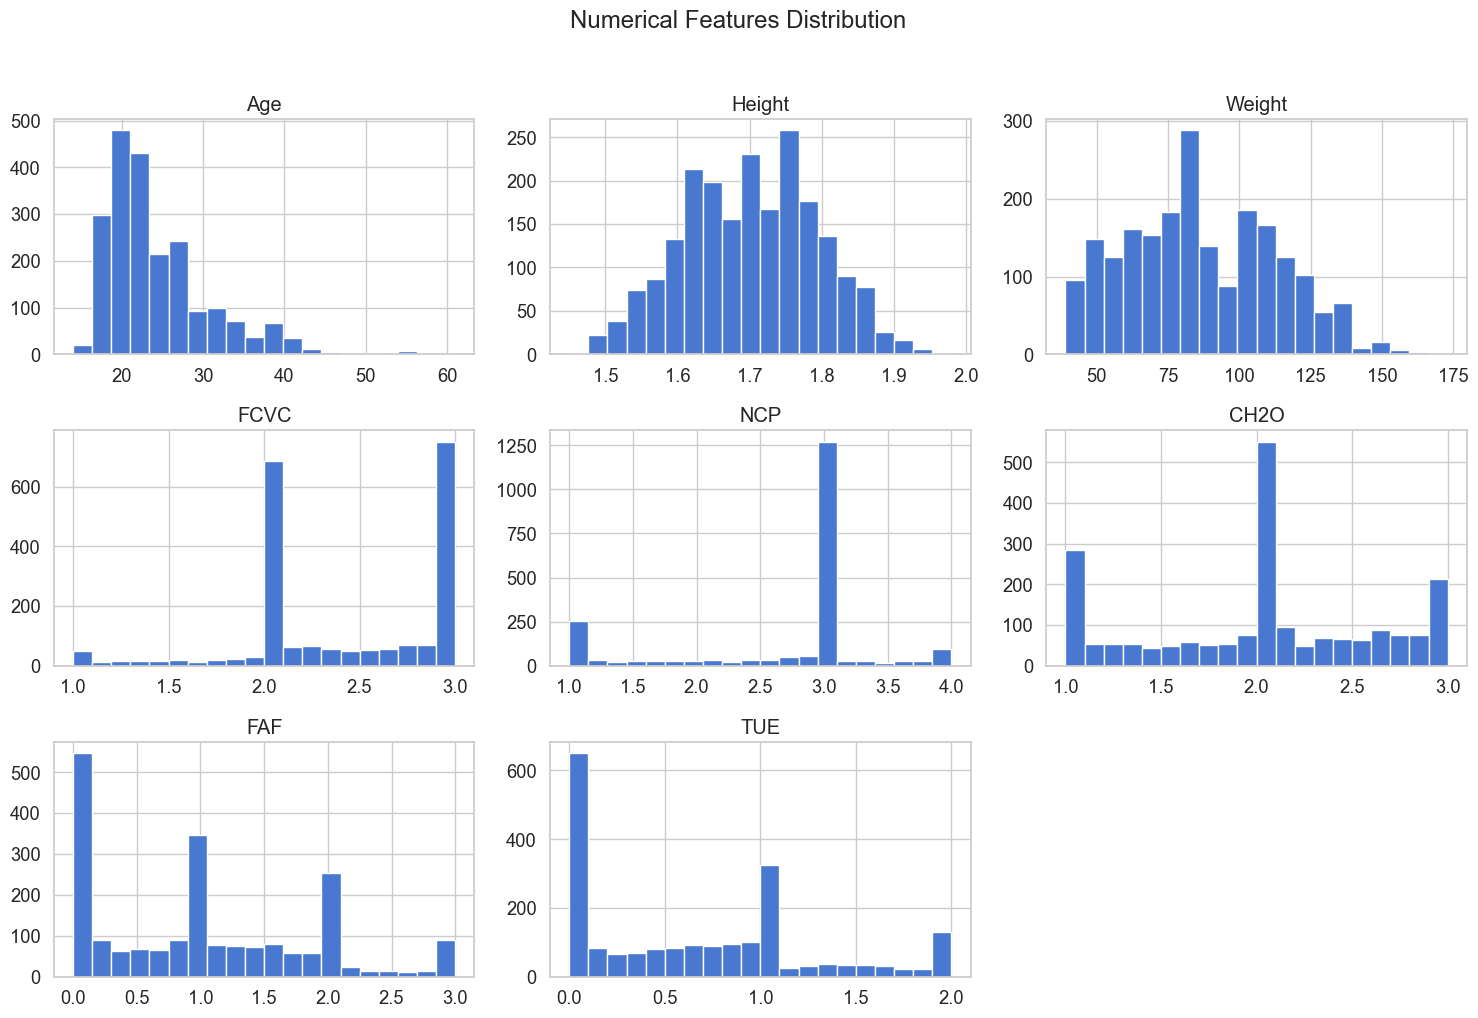

In [9]:
num_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
df[num_features].hist(bins=20, layout=(3, 3), figsize=(15, 10))
plt.suptitle('Numerical Features Distribution', y=1.02)
plt.tight_layout()
plt.show()

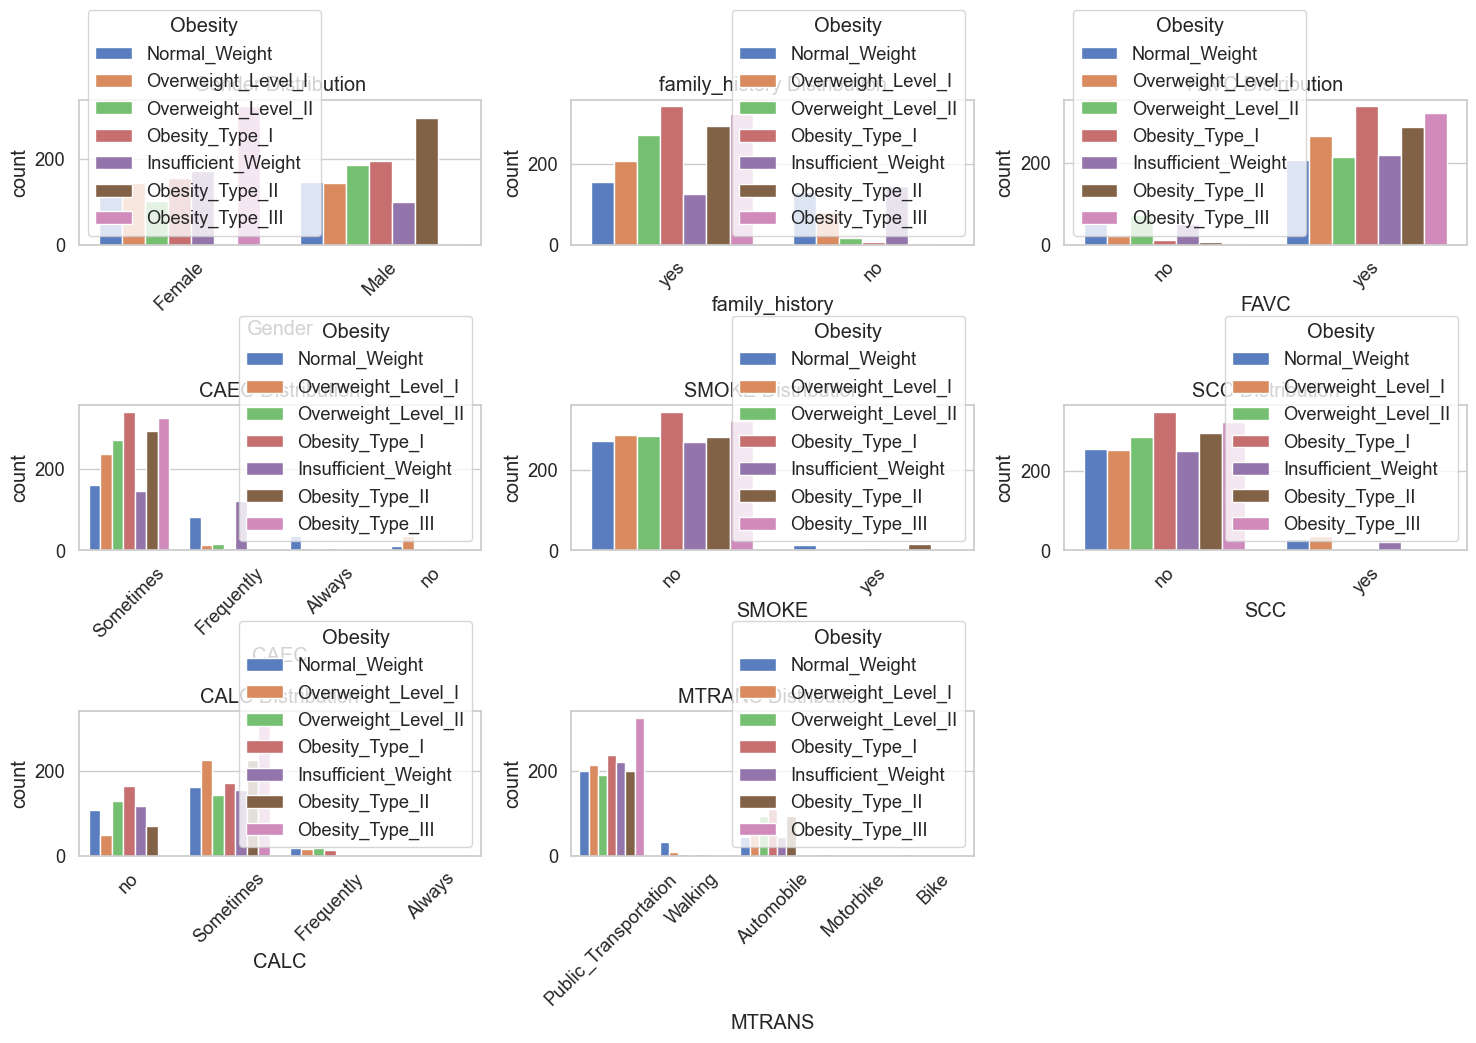

In [10]:
# Categorical Features Analysis
cat_features = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(cat_features, 1):
    plt.subplot(3, 3, i)
    sns.countplot(x=feature, hue='Obesity', data=df)
    plt.xticks(rotation=45)
    plt.title(f'{feature} Distribution')
plt.tight_layout()
plt.show()

In [11]:
# ## 4. Feature Engineering & Preprocessing
# Define preprocessing pipeline
categorical_features = ['Gender', 'family_history', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [12]:
# Handle class imbalance
classes = df['Obesity'].unique()
class_weights = compute_class_weight('balanced', classes=classes, y=df['Obesity'])
class_weight_dict = dict(zip(classes, class_weights))

In [13]:
# ## 5. Model Development
# Prepare data
X = df.drop('Obesity', axis=1)
y = df['Obesity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [14]:
# Define models with hyperparameter grids
models = {
    'RandomForest': {
        'model': RandomForestClassifier(class_weight=class_weight_dict),
        'params': {
            'model__n_estimators': [100, 200],
            'model__max_depth': [None, 10],
            'model__min_samples_split': [2, 5]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'model__n_estimators': [100, 200],
            'model__learning_rate': [0.05, 0.1],
            'model__max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': SVC(class_weight='balanced', probability=True),
        'params': {
            'model__C': [0.1, 1, 10],
            'model__kernel': ['linear', 'rbf']
        }
    }
}

In [15]:
# Train and evaluate models
best_models = {}
for name, config in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', config['model'])
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        config['params'],
        cv=StratifiedKFold(n_splits=5),
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    best_models[name] = {
        'model': grid_search.best_estimator_,
        'score': grid_search.best_score_
    }
    
    print(f"\n{name} Best Parameters:")
    print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits

RandomForest Best Parameters:
{'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 200}
Fitting 5 folds for each of 8 candidates, totalling 40 fits

GradientBoosting Best Parameters:
{'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 200}
Fitting 5 folds for each of 6 candidates, totalling 30 fits

SVM Best Parameters:
{'model__C': 10, 'model__kernel': 'linear'}


In [16]:
# ## 6. Model Evaluation
# Select best model
best_model_name = max(best_models, key=lambda x: best_models[x]['score'])
best_model = best_models[best_model_name]['model']
print(f"\nBest Model: {best_model_name} with F1-score: {best_models[best_model_name]['score']:.3f}")


Best Model: GradientBoosting with F1-score: 0.967



Classification Report:
                     precision    recall  f1-score   support

Insufficient_Weight       1.00      0.93      0.96        54
      Normal_Weight       0.86      0.97      0.91        58
     Obesity_Type_I       0.96      0.94      0.95        70
    Obesity_Type_II       0.97      0.95      0.96        60
   Obesity_Type_III       1.00      0.98      0.99        65
 Overweight_Level_I       0.93      0.91      0.92        58
Overweight_Level_II       0.97      0.98      0.97        58

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



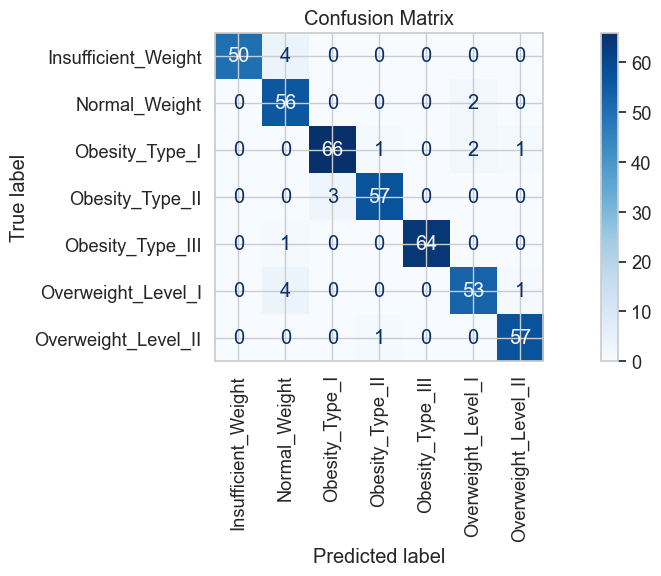

In [17]:
# Generate evaluation report
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test,
                                     cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [18]:
# ## 7. Model Deployment Preparation
# Save preprocessing pipeline and model
joblib.dump(preprocessor, 'obesity_preprocessor.pkl')
joblib.dump(best_model, 'obesity_classifier.pkl')

['obesity_classifier.pkl']